# Poisson equation in 1D with Dirichlet/Robin boundary conditions

## Problem setup

We will solve a Poisson equation:
$$
\nabla^2 u = 2, \qquad x \in [-1, 1]
$$
with the Neumann boundary condtions on the right boundary
$$
\left. \dfrac{du}{dx} \right|_{x=1} = u
$$
and Dirichlet boundary conditions on the left boundary
$$
u(-1) = 0.
$$

The exact solution is $u(x) = (x+1)^2$

## Implementation

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [2]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

2023-10-09 08:44:33.744423: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 08:44:33.744471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 08:44:33.744502: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 08:44:33.752799: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



In [3]:
geom = dde.geometry.Interval(-1, 1)

In [4]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx - 2

In [5]:
def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], -1)

In [7]:
def true_solution(x):
    return (x+1)**2

In [8]:
bc_r = dde.icbc.RobinBC(geom, lambda x, y: y, boundary_r)
bc_l = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)

In [9]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_r, bc_l],
                    num_domain=16,
                    num_boundary=2,
                    solution=true_solution,
                    num_test=100)

In [10]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

2023-10-09 08:46:36.618552: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-09 08:46:36.619400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:82:00.0, compute capability: 7.0


In [11]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

Compiling model...
'compile' took 0.010308 s



Training model...



/userhome/jeon_mg/miniforge3/envs/pinn_tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2023-10-09 08:46:47.884597: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5620ac1c95b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-09 08:46:47.884649: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-09 08:46:47.896990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-09 08:46:48.832313: I tensorflow/compiler

Step      Train loss                        Test loss                         Test metric   
0         [3.98e+00, 2.04e-03, 7.30e-02]    [4.01e+00, 2.04e-03, 7.30e-02]    [9.44e-01]    
1000      [6.42e-05, 1.20e-06, 8.30e-07]    [5.73e-05, 1.20e-06, 8.30e-07]    [7.40e-04]    
2000      [1.08e-05, 3.97e-08, 4.15e-11]    [9.53e-06, 3.97e-08, 4.15e-11]    [3.62e-04]    
3000      [6.50e-06, 4.84e-07, 2.25e-10]    [7.17e-06, 4.84e-07, 2.25e-10]    [1.75e-04]    
4000      [5.87e-06, 8.38e-09, 3.48e-08]    [6.35e-06, 8.38e-09, 3.48e-08]    [2.53e-04]    
5000      [3.45e-04, 4.35e-05, 8.66e-04]    [3.16e-04, 4.35e-05, 8.66e-04]    [7.96e-03]    
6000      [6.49e-06, 1.12e-08, 2.02e-06]    [8.10e-06, 1.12e-08, 2.02e-06]    [5.58e-04]    
7000      [6.97e-06, 2.45e-07, 1.69e-06]    [8.95e-06, 2.45e-07, 1.69e-06]    [4.80e-04]    
8000      [1.08e-05, 2.59e-06, 6.50e-06]    [1.42e-05, 2.59e-06, 6.50e-06]    [6.86e-04]    
9000      [6.08e-06, 9.31e-10, 2.26e-10]    [7.07e-06, 9.31e-10, 2.26e

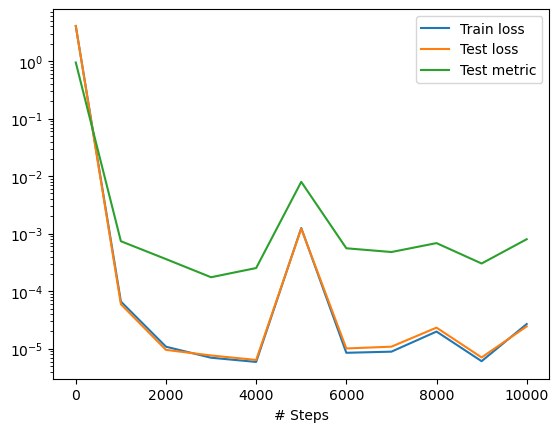

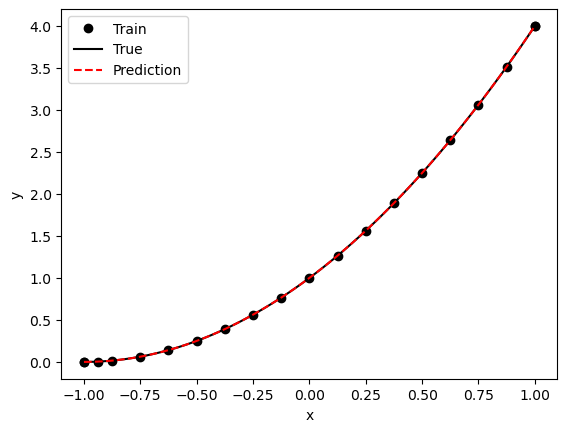

In [12]:
loss_histroy, train_state = model.train(iterations=int(1e4))
dde.saveplot(loss_histroy, train_state, issave=False, isplot=True)